In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIPS
import seaborn as sns
sns.set_context('talk')
plt.rcParams['mathtext.fontset'],plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 14})

import seaborn as sns
sns.set(style='ticks', context='talk')
plt.style.use("M15 Project/paper.mplstyle")

In [5]:
summary = pd.read_csv(f'M15 Project/M15_Data/M15data2020/summary_ver13.csv').set_index('id').sort_values(by='id')

summary

,M15_1_Ndata,M15_1_amplitude,M15_1_chi2/N,M15_1_data_avg_err,M15_1_dec,M15_1_dist,M15_1_fname,M15_1_period,M15_1_period_err,M15_1_ra,...,p_filippenko,p_hogg,confidences,err_cut,periors_mag_lower,mean_mag,type,pf,A1,Af
id,,,,,,,,,,,,,,,,,,,,,
V001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.437712,1.0,NaN,NaN,14.987350,Cepheid,1.437837,0.124436,1.135919
V002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.684349,0.684300,1.0,NaN,NaN,15.741276,RRab,0.684304,0.210554,0.591873
V003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.388761,0.388746,1.0,NaN,NaN,15.828362,RRc,0.519681,0.539936,0.072925
V004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.313575,0.313587,1.0,NaN,NaN,15.919276,RRc,0.416967,0.681267,0.099710
V005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.384221,0.384215,1.0,NaN,NaN,15.783994,RRc,0.512966,0.574212,0.112296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V150,108.0,0.326149,0.148939,0.037587,12.171433,4.155563,012.dat,0.211537,3.161548e-08,322.495005,...,NaN,NaN,0.0,NaN,NaN,13.148673,??,1.043201,0.331267,0.315676
V152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V154,94.0,0.402302,0.159669,0.042429,12.171207,4.053970,011.dat,0.328257,7.006943e-08,322.491365,...,NaN,NaN,0.0,NaN,NaN,13.001821,??,0.864274,0.403683,0.437934


In [18]:
def getdata_filtered(name):
    path = "M15 Project/M15_Data/" + summary.loc[name,'field']+'/summary/'+summary.loc[name,'H&M_id'][-3:]+'.dat'
    period = summary.loc[name]['period']
    data_V = PIPS.data_readin_LPP(path,filter='V')
    data_B = PIPS.data_readin_LPP(path,filter='B')
    
    # B-V estimate: mean difference of B-band against the nearest available V-band observations
    B_V = np.mean([(data_B[1][i]-data_V[1][abs(data_V[0]-data_B[0][i]).argmin()]) for i in range(len(data_B[1]))])
                   
    # prepare to cut bad datapoints
    err_threshold = None if np.isnan(summary.loc[name,'err_cut']) else summary.loc[name,'err_cut']
    mag_upper = None if np.isnan(summary.loc[name]['priors_mag_upper']) else summary.loc[name]['priors_mag_upper']
    mag_lower = None if np.isnan(summary.loc[name]['priors_mag_lower']) else summary.loc[name]['priors_mag_lower']

    # construct PIPS photdata object
    original = PIPS.photdata(data_V)
    original.err_cut_threshold = err_threshold
    filtered = original.phot_err_cut().phot_mag_cut(mag_upper,mag_lower)
    filtered.period = period
    filtered.label = name
    filtered.B_V = B_V
    filtered.N_B = len(data_B[1])
    filtered.get_epoch();
    
    def get_uncertainty(phot_obj,period=None):
        if period==None:
            period = phot_obj.period
        ab = np.full(2*5,1)
        p0=[period,15,*ab]
        FF_popt,FF_pcov = curve_fit(phot_obj.fourier_composition_folded,
                                    phot_obj.x, phot_obj.y, sigma=phot_obj.yerr,
                                    p0=p0,maxfev=1000000)
        phot_obj.period_err = np.sqrt(np.diag(FF_pcov))[0]
        phot_obj.Fourier_params_errors = np.sqrt(np.diag(FF_pcov))[1:]
        phot_obj.Fourier_params = FF_popt[1:]
        return phot_obj
    
    get_uncertainty(filtered, filtered.period)
    # characteristic intrinsic scatter: see section 2.2.2 in our paper
    new_yerr = []
    for i in filtered.yerr:
        new_yerr.append(0.03 if i<0.03 else i)
    filtered.yerr = np.array(new_yerr)
    filtered.mag_err = filtered.yerr
        
    return filtered

In [19]:
from scipy.optimize import curve_fit

def fit_cphi(x,y,period,K):
    def f(x_folded,A0,*cp_list):
        c_list = cp_list[0:K]
        p_list = cp_list[K:]
        y = A0
        for i in range(len(c_list)):
            y += c_list[i]*np.cos((i+1)*2*np.pi*x_folded/period + p_list[i])
        return y
    
    p0 = [1,*np.zeros(K*2)]
    popt,pcov = curve_fit(f,x%period,y,p0=p0)
    return popt,pcov

$$\delta y = \sqrt{\left(\frac{\partial y}{\partial x_i} \delta x_i \right)^2}$$

In [20]:
"""RRab Type Star Functions for Stellar Properties"""

def Fe_H_ab(period, phi):
    phi_s = phi + np.pi# + 0.151
    return -5.241 - 5.394*period + 1.345*phi_s

def BV_0(period, C_1, C_3):
    return 0.189*np.log10(period) -0.313*C_1 + 0.293*C_3 + 0.460

def log_T_eff_type_ab(BV, metallicity):
    return 3.930 - 0.322*BV + 0.007*metallicity

def M_v_ab(period, C_1, C_3):
    return -1.876*np.log10(period) - 1.158*C_1 + 0.821*C_3 + 0.43

def log_L_ab(period,C_1, C_3):
    M_v = -1.876*np.log10(period) - 1.158*C_1 + 0.821*C_3 + 0.43
    return (M_v - 4.83)/(-2.5)

def log_mass_ab(period, log_L, log_T_eff, metal):
    return 20.844 - 1.754*np.log10(period) + 1.477*(log_L) - 6.272*log_T_eff + 0.0367*metal


def error_Fe_H_ab(p_err, phi_err):
    return np.sqrt((-5.394*p_err)**2 + (1.345*phi_err)**2)

def error_BV_0(period,p_err, C_1_err, C_3_err):
    return np.sqrt(((0.189/np.log(10))*(p_err/period))**2 + (-0.313*C_1_err)**2 + (0.293*C_3_err)**2)

def error_log_T_eff_type_ab(BV_err, metallicity_err):
    return np.sqrt((0.322*BV_err)**2 + (0.007*metallicity_err)**2)

def error_M_v_ab(period, p_err, C_1_err, C_3_err):
    return np.sqrt(((-1.876/np.log(10))*(p_err/period))**2 + (-1.158*C_1_err)**2 + (0.821*C_3_err)**2)

def error_log_L_ab(period,p_err,C_1_err, C_3_err):
    L_err = np.sqrt((((1.876/2.5)/np.log(10))*(p_err/period))**2 + (1.158*C_1_err/2.5)**2 + (0.821*C_3_err/2.5)**2)
    return L_err 

def error_log_mass_ab(period,p_err, log_L_err, log_T_eff_err, metal_err):
    return np.sqrt(((-1.754/np.log(10))*(p_err/period))**2 + (1.477*(log_L_err))**2 + (-6.272*log_T_eff_err)**2 + (0.0367*metal_err)**2)
    


"""RRc Type Star Functions for Stellar Properties"""

def Fe_H_c(period, phi):
    #phi is phi_31
    phi_s = phi + np.pi
    return 0.0348*phi_s**2 + 0.196*phi - 8.507*period + 0.367

def log_T_eff_type_c(period, phi):
    phi_s = phi + np.pi
    return 3.7746 - 0.1452*np.log10(period) + 0.0056*phi_s

def M_v_c(period, phi, C4):
    phi_s = phi - np.pi/2
    return 1.061 - 0.961*np.log10(period) - 0.044*phi_s - 4.447*C4

def log_L_c(period,phi, C4):
    phi_s = phi - np.pi/2
    M_v = 1.061 - 0.961*np.log10(period) - 0.044*phi_s - 4.447*C4
    return (M_v - 4.83)/(-2.5)

def log_mass_c(period, phi):
    phi_s = phi + np.pi
    return 0.52 * np.log10(period) - 0.11*phi_s + 0.39


def error_Fe_H_c(p_err, phi_err, phi):
    #phi is phi_31
    phi_s = phi + np.pi
    return (2*0.0348*phi_s * phi_err)**2 + (0.196*phi_err)**2 + (-8.507*p_err)**2

def error_log_T_eff_type_c(period,p_err, phi_err):
    #phi_s = phi + np.pi 
    return np.sqrt(((- 0.1452/np.log(10))*(p_err/period))**2 + (0.0056*phi_err)**2)

def error_M_v_c(period,p_err, phi_err, C4_err):
    return np.sqrt(((- 0.961/np.log(10))*(p_err/period))**2 + (-0.044*phi_err)**2 +  (-4.447*C4_err)**2)

def error_log_L_c(period,p_err, phi_err, C4_err):
    L_err = (((0.961/2.5)/np.log(10))*(p_err/period))**2 + (- 0.044*phi_err/2.5)**2 + (-4.447*C4_err/2.5)**2
    return L_err

def error_log_mass_c(period,p_err, phi_err):
    return np.sqrt(((0.52/np.log(10))*(p_err/period))**2 + (-0.11*phi_err)**2)

"""Functions for all stars"""

def log_surface_gravity(log_mass, log_L, log_T_eff):
    return -10.607 + log_mass - log_L + 4*log_T_eff

def error_log_surface_gravity(log_mass_err, log_L_err, log_T_eff_err):
    return np.sqrt(log_mass_err**2  + log_L_err**2 + (4*log_T_eff_err)**2)
    

In [21]:
RRab = summary['type']=='RRab'
RRc = summary['type']=='RRc'


In [22]:
K=4

# initialize new columns
for col in ['C_1','C_2', 'C_3', 'C_4','phi_21','phi_31','phi_41']:
    summary[col] = np.nan

for col in ['[Fe/H]','BV_0','log T_eff', 'M_v', 'log L','mass','log g']:
    summary[col] = np.nan
    
for col in ['err_C_1','err_C_2', 'err_C_3', 'err_C_4','err_phi_21','err_phi_31','err_phi_41']:
    summary[col] = np.nan

for col in ['err_[Fe/H]','err_BV_0','err_log T_eff', 'err_M_v', 'err_log L','err_mass','err_log g']:
    summary[col] = np.nan
    
    
# get values
for name in summary[RRab].index.values:
    star = getdata_filtered(name)
    popt,pcov = fit_cphi(star.x-star.epoch[0]%star.period,star.y,star.period,K=4)
    
    errors = []
    for j in range(len(popt)):
        err = np.sqrt(pcov[j,j])
        errors.append(err)
    
    err_c_1, err_c_2, err_c_3, err_c_4 = errors[1], errors[2], errors[3], errors[4]
    err_phi21 = np.sqrt( (errors[6])**2 + (-2 * errors[5])**2 )
    err_phi31 = np.sqrt( (errors[7])**2 + (-3 * errors[5])**2 )
    err_phi41 = np.sqrt( (errors[8])**2 + (-4 * errors[5])**2 )
    
    for i in range(K):
        if popt[i+1]<0:
            popt[i+K+1] += np.pi
            popt[i+1] *= -1
        popt[i+5] = popt[i+5]%(2*np.pi)
        
    c_1, c_2, c_3, c_4 = popt[1], popt[2], popt[3], popt[4]
    phi21 = (popt[6] - 2*popt[5])%(2*np.pi)
    phi31 = (popt[7] - 3*popt[5])%(2*np.pi)
    phi41 = (popt[8] - 4*popt[5])%(2*np.pi)
    
    Fe_H_value = Fe_H_ab(star.period, phi31)
    BV_0_value = BV_0(star.period,c_1, c_3)
    log_T_eff_value = log_T_eff_type_ab(BV_0_value, Fe_H_value)
    M_v_value = M_v_ab(star.period, c_1, c_3)
    log_L_value = log_L_ab(star.period, c_1, c_3)
    log_mass_value = log_mass_ab(star.period, log_L_value, log_T_eff_value, Fe_H_value)
    log_g_value = log_surface_gravity(log_mass_value, log_L_value, log_T_eff_value)
    
    
    error_Fe_H_value = error_Fe_H_ab(star.period_err, err_phi31)
    error_BV_0_value = error_BV_0(star.period,star.period_err,err_c_1, err_c_3)
    error_log_T_eff_value = error_log_T_eff_type_ab(error_BV_0_value, error_Fe_H_value)
    error_M_v_value = error_M_v_ab(star.period,star.period_err, err_c_1, err_c_3)
    error_log_L_value = error_log_L_ab(star.period,star.period_err, err_c_1, err_c_3)
    error_log_mass_value = error_log_mass_ab(star.period,star.period_err, error_log_L_value, error_log_T_eff_value, error_Fe_H_value)
    error_log_g_value = error_log_surface_gravity(error_log_mass_value, error_log_L_value, error_log_T_eff_value)
    
    
    summary.loc[name, ['period_err']] = star.period_err

    summary.loc[name,['C_1','C_2', 'C_3', 'C_4','phi_21','phi_31','phi_41']] = [c_1,c_2,c_3,c_4,phi21,phi31,phi41]
    summary.loc[name,['[Fe/H]','BV_0','log T_eff', 'M_v', 'log L','mass','log g']] = [Fe_H_value, BV_0_value,log_T_eff_value, M_v_value,
                                                                             log_L_value, 10**log_mass_value, log_g_value]
    
    summary.loc[name,['err_C_1','err_C_2', 'err_C_3', 'err_C_4','err_phi_21','err_phi_31','err_phi_41']] = [err_c_1,err_c_2,err_c_3,err_c_4,
                                                                                                            err_phi21,err_phi31,err_phi41]
    summary.loc[name,['err_[Fe/H]','err_BV_0','err_log T_eff', 'err_M_v', 'err_log L','err_mass','err_log g']] = [error_Fe_H_value,error_BV_0_value, error_log_T_eff_value,
                                                                                                       error_M_v_value, error_log_L_value,
                                                                                                       error_log_mass_value, error_log_g_value]
    
# get values
for name in summary[RRc].index.values:
    star = getdata_filtered(name)
    popt,pcov = fit_cphi(star.x-star.epoch[0]%star.period,star.y,star.period,K=4)
    
    errors = []
    for j in range(len(popt)):
        err = np.sqrt(pcov[j,j])
        errors.append(err)
    
    err_c_1, err_c_2, err_c_3, err_c_4 = errors[1], errors[2], errors[3], errors[4]
    err_phi21 = np.sqrt( (errors[6])**2 + (-2 * errors[5])**2 )
    err_phi31 = np.sqrt( (errors[7])**2 + (-3 * errors[5])**2 )
    err_phi41 = np.sqrt( (errors[8])**2 + (-4 * errors[5])**2 )
    
    for i in range(K):
        if popt[i+1]<0:
            popt[i+K+1] += np.pi
            popt[i+1] *= -1
        popt[i+5] = popt[i+5]%(2*np.pi)
        
    c_1, c_2, c_3, c_4 = popt[1], popt[2], popt[3], popt[4]
    phi21 = (popt[6] - 2*popt[5])%(2*np.pi)
    phi31 = (popt[7] - 3*popt[5])%(2*np.pi)
    phi41 = (popt[8] - 4*popt[5])%(2*np.pi)
    
    Fe_H_value = Fe_H_c(star.period, phi31)
    log_T_eff_value = log_T_eff_type_c(star.period, phi31)
    M_v_value = M_v_c(star.period, phi21, c_4)
    log_L_value = log_L_c(star.period, phi21, c_4)
    log_mass_value = log_mass_c(star.period, phi31)
    log_g_value = log_surface_gravity(log_mass_value, log_L_value, log_T_eff_value)
    
    error_Fe_H_value = error_Fe_H_c(star.period_err, err_phi31, phi31)
    error_log_T_eff_value = error_log_T_eff_type_c(star.period,star.period_err, err_phi31)
    error_M_v_value = error_M_v_c(star.period,star.period_err, err_phi21, err_c_4)
    error_log_L_value = error_log_L_c(star.period,star.period_err, err_phi21, err_c_4)
    error_log_mass_value = error_log_mass_c(star.period,star.period_err, err_phi31)
    error_log_g_value = error_log_surface_gravity(error_log_mass_value, error_log_L_value, error_log_T_eff_value)
    
    
    summary.loc[name, ['period_err']] = star.period_err

    summary.loc[name,['C_1','C_2', 'C_3', 'C_4','phi_21','phi_31','phi_41']] = [c_1,c_2,c_3,c_4,phi21,phi31,phi41]
    summary.loc[name,['[Fe/H]','log T_eff', 'M_v', 'log L','mass','log g']] = [Fe_H_value, log_T_eff_value, M_v_value,
                                                                             log_L_value, 10**log_mass_value, log_g_value]
    
    summary.loc[name,['err_C_1','err_C_2', 'err_C_3', 'err_C_4','err_phi_21','err_phi_31','err_phi_41']] = [err_c_1,err_c_2,err_c_3,err_c_4,
                                                                                                            err_phi21,err_phi31,err_phi41]
    summary.loc[name,['err_[Fe/H]','err_log T_eff', 'err_M_v', 'err_log L','err_mass','err_log g']] = [error_Fe_H_value, error_log_T_eff_value,
                                                                                                       error_M_v_value, error_log_L_value,
                                                                                                       error_log_mass_value, error_log_g_value]

In [23]:
summary[RRab]

,M15_1_Ndata,M15_1_amplitude,M15_1_chi2/N,M15_1_data_avg_err,M15_1_dec,M15_1_dist,M15_1_fname,M15_1_period,M15_1_period_err,M15_1_ra,...,err_phi_21,err_phi_31,err_phi_41,err_[Fe/H],err_BV_0,err_log T_eff,err_M_v,err_log L,err_mass,err_log g
id,,,,,,,,,,,,,,,,,,,,,
V002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.083277,0.148768,0.220528,0.200092,0.002796,0.001665,0.009368,0.003747,0.013914,0.015875
V006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.127646,0.180220,0.232411,0.242395,0.004927,0.002323,0.015746,0.006298,0.019440,0.022448
V008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.077762,0.104908,0.140702,0.141101,0.003102,0.001405,0.010212,0.004085,0.011868,0.013752
V009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.036033,0.055217,0.087467,0.074267,0.001541,0.000719,0.005099,0.002040,0.006068,0.007018
V012,120.0,0.832100,0.223849,0.016018,12.153530,0.921717,081.dat,0.592876,5.150954e-07,322.538721,...,0.090094,0.149899,0.224566,0.201614,0.003559,0.001818,0.012027,0.004811,0.015338,0.017643
V013,120.0,1.020394,0.086689,0.013124,12.148511,0.438942,073.dat,0.574911,1.431153e-07,322.528775,...,0.049492,0.075442,0.099309,0.101470,0.002811,0.001150,0.009421,0.003768,0.009844,0.011502
V015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.138996,0.239139,0.363162,0.321641,0.004996,0.002767,0.016478,0.006591,0.023137,0.026482
V019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.058172,0.080067,0.112940,0.107691,0.003853,0.001452,0.012713,0.005085,0.012447,0.014646
V020,137.0,0.903812,0.081011,0.012888,12.164764,0.556124,075.dat,0.696954,2.872878e-06,322.515586,...,0.047532,0.066831,0.112830,0.089887,0.002245,0.000958,0.007524,0.003009,0.008172,0.009515


-2.224749725856142
-0.9965881533662387


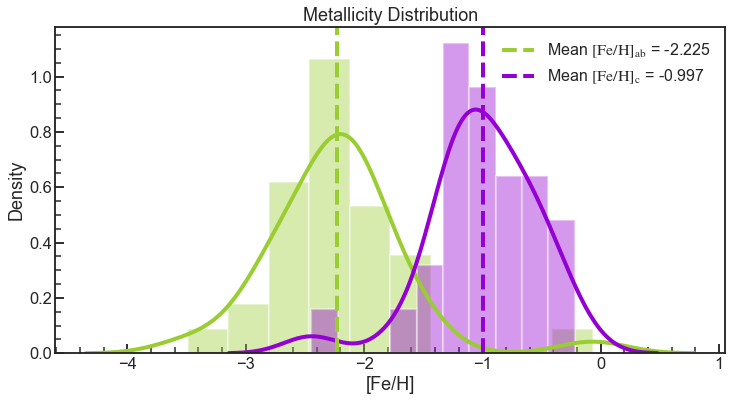

In [24]:
metallicity_ab = summary[RRab]['[Fe/H]']
metallicity_c = summary[RRc]['[Fe/H]']
mean_ab = np.mean(metallicity_ab[metallicity_ab<0])
print(mean_ab)



mean_c = np.mean(metallicity_c[metallicity_c<0])

mean_ab_short = '{0:0.3f}'.format(mean_ab)
mean_c_short = '{0:0.3f}'.format(mean_c)
print(mean_c)
plt.figure(figsize=(12,6))
plt.title("Metallicity Distribution")
sns.distplot(metallicity_ab[metallicity_ab<0],bins=10, color='yellowgreen')
sns.distplot(metallicity_c[metallicity_c<0],bins=10,color='darkviolet')
plt.axvline(mean_ab,label="Mean $[\mathrm{Fe/H}]_{\mathrm{ab}}$ = " + mean_ab_short, c='yellowgreen', linestyle='--')
plt.axvline(mean_c,label="Mean $[\mathrm{Fe/H}]_{\mathrm{c}}$ = " + mean_c_short,c='darkviolet', linestyle='--')
plt.legend()
#plt.savefig('metallicity_fixed.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

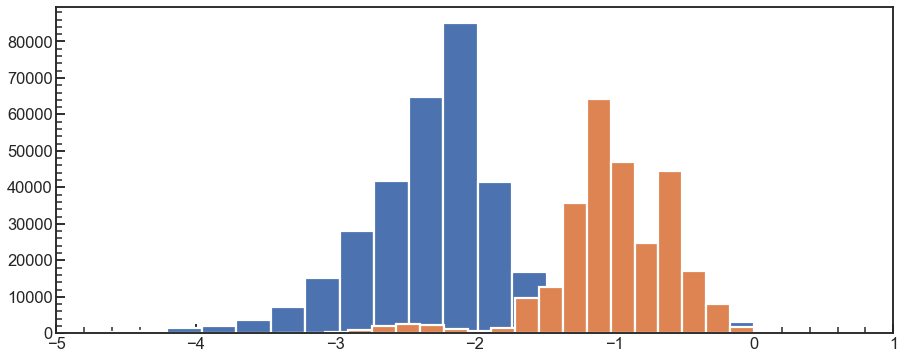

-2.255119158829315
-1.0148009114169605


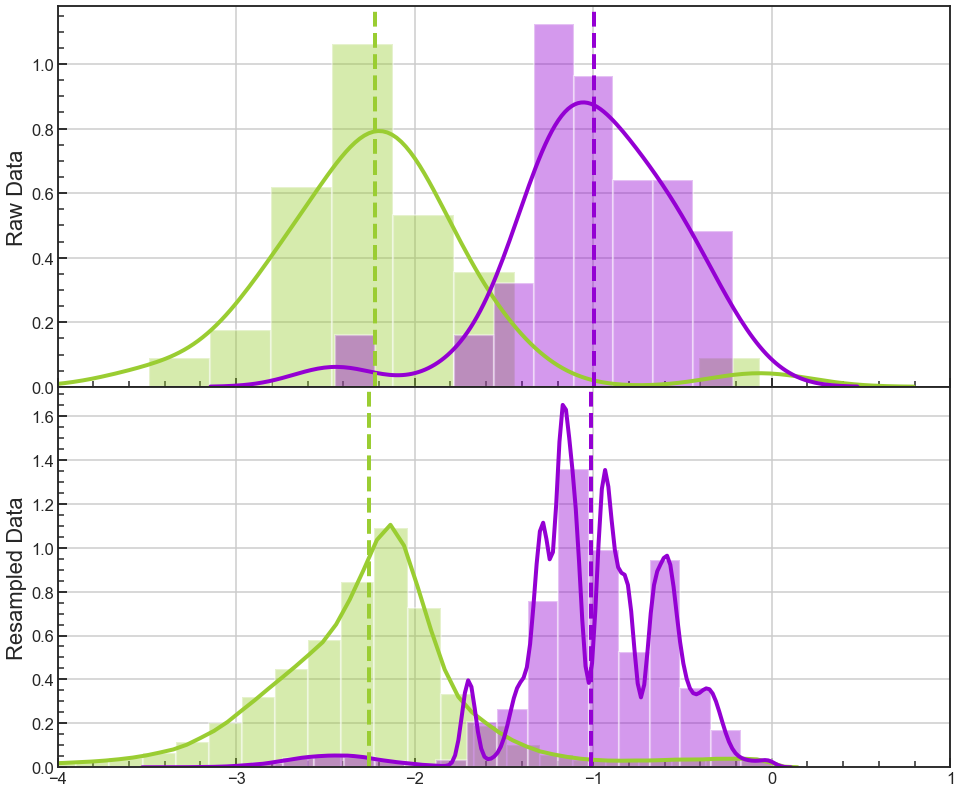

The difference between between the the raw data and the resampled data is non-zero.
We find that the difference in mean metallicity for RRab stars is |0.030| and the difference
for RRc stars is |0.018|


In [25]:
#Resampling

metallicity_ab_err = summary[RRab]['err_[Fe/H]']
metallicity_c_err = summary[RRc]['err_[Fe/H]']

metallicity_ab = summary[RRab]['[Fe/H]']
metallicity_c = summary[RRc]['[Fe/H]']

samples_ab = []
for i in range(len(metallicity_ab)):
    sample_ab_i = np.random.normal(loc=metallicity_ab[i], scale=metallicity_ab_err[i], size=10000)
    samples_ab.append(sample_ab_i)
    
metallicity_ab_resampled = np.concatenate(samples_ab)

samples_c = []
for i in range(len(metallicity_c)):
    sample_c_i = np.random.normal(loc=metallicity_c[i], scale=metallicity_c_err[i], size=10000)
    samples_c.append(sample_c_i)
    
metallicity_c_resampled = np.concatenate(samples_c)

plt.figure()
plt.xlim(-5,1)
plt.hist(metallicity_ab_resampled[metallicity_ab_resampled<0],bins=60);
plt.hist(metallicity_c_resampled[metallicity_c_resampled<0],bins=20);
plt.show()

mean_metallicity_ab_resampled = np.mean(metallicity_ab_resampled[metallicity_ab_resampled<0])
mean_metallicity_c_resampled = np.mean(metallicity_c_resampled[metallicity_c_resampled<0])

print(mean_metallicity_ab_resampled)
print(mean_metallicity_c_resampled)


mean_ab_resamp_short = '{0:0.3f}'.format(mean_metallicity_ab_resampled)
mean_c_resamp_short = '{0:0.3f}'.format(mean_metallicity_c_resampled)

#PLOT THE FIGURE
fig, axes = plt.subplots(2,1, figsize=(16,14),sharex=True)  # 2 Rows, 1 Column
fig.subplots_adjust(hspace=0)


axes[0].set_ylabel("Raw Data",fontsize=22)
sns.distplot(metallicity_ab[metallicity_ab<0],bins=10, color='yellowgreen',ax=axes[0])
sns.distplot(metallicity_c[metallicity_c<0],bins=10,color='darkviolet',ax=axes[0])
axes[0].axvline(mean_ab,label="Mean $[\mathrm{Fe/H}]_{\mathrm{ab}}$ = " + mean_ab_short, c='yellowgreen', linestyle='--')
axes[0].axvline(mean_c,label="Mean $[\mathrm{Fe/H}]_{\mathrm{c}}$ = " + mean_c_short,c='darkviolet', linestyle='--')
axes[0].grid()

axes[1].set_ylabel("Resampled Data",fontsize=22)
sns.distplot(metallicity_ab_resampled[metallicity_ab_resampled<0],bins=80, color='yellowgreen',ax=axes[1])
sns.distplot(metallicity_c_resampled[metallicity_c_resampled<0],bins=20,color='darkviolet',ax=axes[1])
axes[1].axvline(mean_metallicity_ab_resampled,label="Mean $[\mathrm{Fe/H}]_{\mathrm{ab}}$ = " + mean_ab_resamp_short
                , c='yellowgreen', linestyle='--')
axes[1].axvline(mean_metallicity_c_resampled,label="Mean $[\mathrm{Fe/H}]_{\mathrm{c}}$ = " + mean_c_resamp_short
                ,c='darkviolet', linestyle='--')
axes[1].grid()

#plt.legend()
plt.xlim(-4,1)
plt.show()

print("""The difference between between the the raw data and the resampled data is non-zero.
We find that the difference in mean metallicity for RRab stars is |{0:0.3f}| and the difference
for RRc stars is |{1:0.3f}|""".format(abs(mean_ab - mean_metallicity_ab_resampled), 
                                      abs(mean_c - mean_metallicity_c_resampled)))

# plt.figure()
# plt.xlim(-5,1)
# sns.distplot(metallicity_ab_resampled[metallicity_ab_resampled<0],bins=80, color='yellowgreen')
# sns.distplot(metallicity_c_resampled[metallicity_c_resampled<0],bins=20,color='darkviolet')

# sns.distplot(metallicity_ab[metallicity_ab<0],bins=10, color='lime')
# sns.distplot(metallicity_c[metallicity_c<0],bins=10,color='purple')
# plt.show()

In [26]:
AB_df = summary[RRab][['C_1','C_2', 'C_3', 'C_4','phi_21','phi_31','phi_41','[Fe/H]','log T_eff', 'M_v', 'log L','mass','log g']]

In [27]:
AB_df = summary[RRab][['C_1','C_2', 'C_3', 'C_4','phi_21','phi_31','phi_41','[Fe/H]','log T_eff', 'M_v', 'log L','mass','log g']]
C_df = summary[RRc][['C_1','C_2', 'C_3', 'C_4','phi_21','phi_31','phi_41','[Fe/H]','log T_eff', 'M_v', 'log L','mass','log g']]

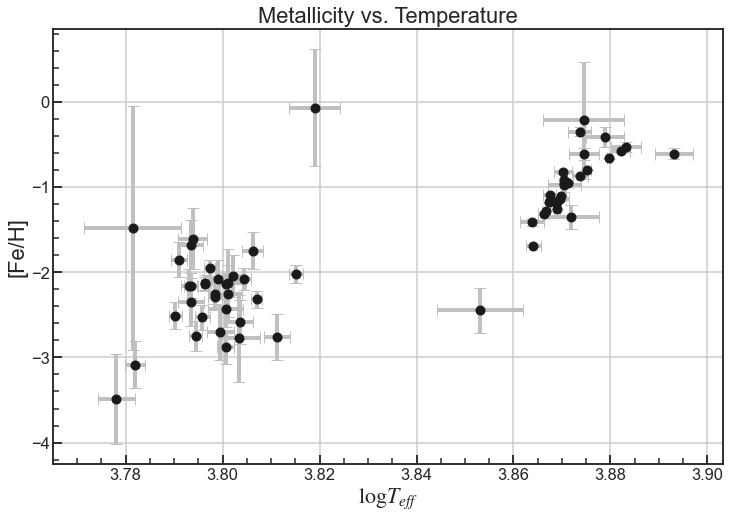

In [28]:
plt.figure(figsize=(12,8))
plt.title("Metallicity vs. Temperature",fontsize=22)
plt.ylabel("[Fe/H]",fontsize=22)
plt.xlabel("$\\log T_{eff}$",fontsize=22)
plt.errorbar(summary['log T_eff'][summary['[Fe/H]'] < 0], summary['[Fe/H]'][summary['[Fe/H]'] < 0], 
             summary['err_[Fe/H]'][summary['[Fe/H]'] < 0], summary['err_log T_eff'][summary['[Fe/H]'] < 0], fmt='o',
            color='k', ecolor='silver', capsize=6)
plt.grid()
plt.show()

# Useful Plots Begin Here

In [29]:
summary

,M15_1_Ndata,M15_1_amplitude,M15_1_chi2/N,M15_1_data_avg_err,M15_1_dec,M15_1_dist,M15_1_fname,M15_1_period,M15_1_period_err,M15_1_ra,...,err_phi_21,err_phi_31,err_phi_41,err_[Fe/H],err_BV_0,err_log T_eff,err_M_v,err_log L,err_mass,err_log g
id,,,,,,,,,,,,,,,,,,,,,
V001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.083277,0.148768,0.220528,0.200092,0.002796,0.001665,0.009368,0.003747,0.013914,0.015875
V003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.044368,0.083213,0.168085,0.001438,NaN,0.000466,0.008389,0.000011,0.009153,0.009341
V004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.027891,0.081227,0.111467,0.001294,NaN,0.000455,0.010159,0.000017,0.008935,0.009118
V005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.055714,0.133784,0.249444,0.003480,NaN,0.000749,0.011046,0.000020,0.014716,0.015018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V150,108.0,0.326149,0.148939,0.037587,12.171433,4.155563,012.dat,0.211537,3.161548e-08,322.495005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V154,94.0,0.402302,0.159669,0.042429,12.171207,4.053970,011.dat,0.328257,7.006943e-08,322.491365,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
AB_df = summary[RRab][['C_1','C_2', 'C_3', 'C_4','phi_21','phi_31','phi_41','[Fe/H]','BV_0','log T_eff', 'M_v', 'log L','mass','log g']]
C_df = summary[RRc][['C_1','C_2', 'C_3', 'C_4','phi_21','phi_31','phi_41','[Fe/H]','log T_eff', 'M_v', 'log L','mass','log g']]
# AB_df.to_latex('RRab1.tex',na_rep='-',float_format='{:.3f}'.format)
# C_df.to_latex('RRc1.tex',na_rep='-',float_format='{:.3f}'.format)

AB_df.to_csv("RRab_Values.csv")
C_df.to_csv("RRc_Values.csv")

In [31]:
AB_err_df = summary[RRab][['err_C_1','err_C_2', 'err_C_3', 'err_C_4','err_phi_21','err_phi_31','err_phi_41','err_[Fe/H]','err_BV_0','err_log T_eff', 'err_M_v', 'err_log L','err_mass','err_log g']]
C_err_df = summary[RRc][['err_C_1','err_C_2', 'err_C_3', 'err_C_4','err_phi_21','err_phi_31','err_phi_41','err_[Fe/H]','err_log T_eff', 'err_M_v', 'err_log L','err_mass','err_log g']]

# AB_err_df.to_latex('RRab1_err.tex',na_rep='-',float_format='{:.3e}'.format)
# C_err_df.to_latex('RRc1_err.tex',na_rep='-',float_format='{:.3e}'.format)

AB_err_df.to_csv("RRab_Errors.csv")
C_err_df.to_csv("RRc_Errors.csv")

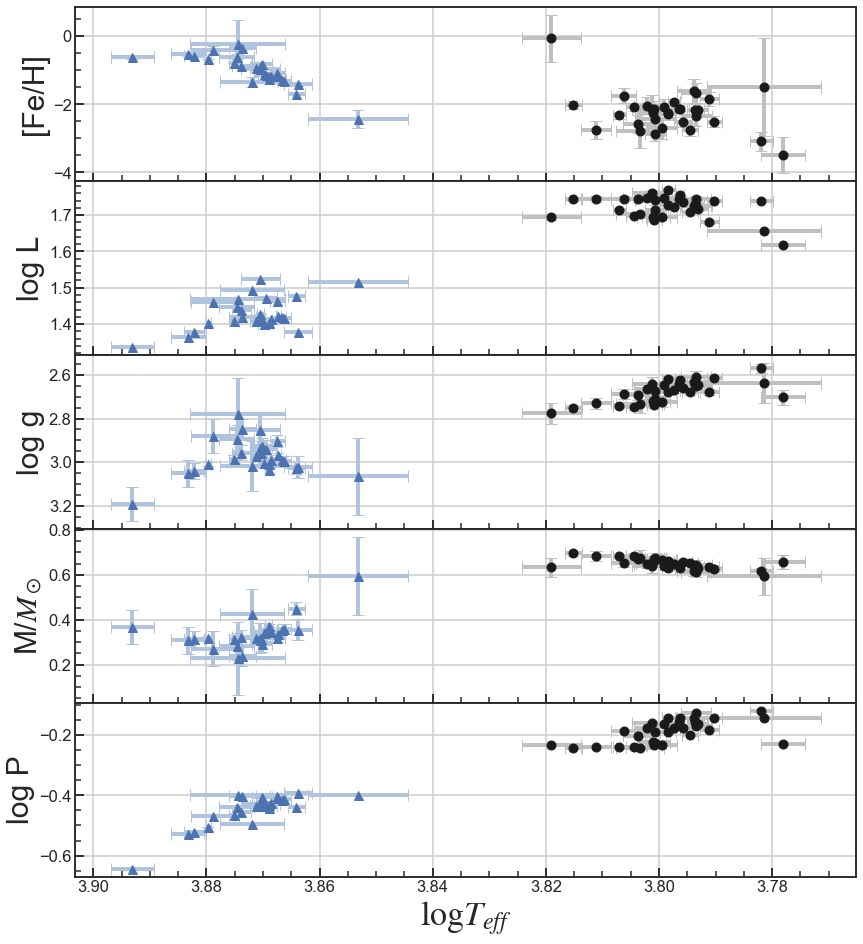

In [32]:
#create a figure with 2 graphs oriented one way
#create a figure with 2 graphs oriented one way
metallicity_ab = summary[RRab]['[Fe/H]'][summary[RRab]['[Fe/H]'] < 0] 
metallicity_c = summary[RRc]['[Fe/H]'][summary[RRc]['[Fe/H]'] < 0] 
#empirical_temp = summary['log T_eff empirical'][summary['[Fe/H]'] < 0]

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(14,16),sharex=True)  # 2 Rows, 1 Column
fig.subplots_adjust(hspace=0)


ax1.set_ylabel("[Fe/H]",fontsize=30)
ax1.errorbar(summary[RRab]['log T_eff'][summary[RRab]['[Fe/H]'] < 0], metallicity_ab,
             summary[RRab]['err_[Fe/H]'][summary[RRab]['[Fe/H]'] < 0], 
             summary[RRab]['err_log T_eff'][summary[RRab]['[Fe/H]'] < 0], fmt='o', color='k',
             ecolor='silver', capsize=6)

ax1.errorbar(summary[RRc]['log T_eff'][summary[RRc]['[Fe/H]'] < 0], metallicity_c,
            summary[RRc]['err_[Fe/H]'][summary[RRc]['[Fe/H]'] < 0], 
            summary[RRc]['err_log T_eff'][summary[RRc]['[Fe/H]'] < 0], fmt='^',
            color='b', ecolor='lightsteelblue', capsize=6)
#ax1.scatter(empirical_temp, metallicity, color='r')
ax1.grid()

ax2.set_ylabel("log L",fontsize=30)
ax2.errorbar(summary[RRab]['log T_eff'][summary[RRab]['[Fe/H]'] < 0],
             summary[RRab]['log L'][summary[RRab]['[Fe/H]'] < 0] ,
             summary[RRab]['err_log L'][summary[RRab]['[Fe/H]'] < 0], 
             summary[RRab]['err_log T_eff'][summary[RRab]['[Fe/H]'] < 0], fmt='o', color='k',
             ecolor='silver', capsize=6)
ax2.errorbar(summary[RRc]['log T_eff'][summary[RRc]['[Fe/H]'] < 0], 
             summary[RRc]['log L'][summary[RRc]['[Fe/H]'] < 0] ,
            summary[RRc]['err_log L'][summary[RRc]['[Fe/H]'] < 0], 
            summary[RRc]['err_log T_eff'][summary[RRc]['[Fe/H]'] < 0], fmt='^',
            color='b', ecolor='lightsteelblue', capsize=6)
#ax2.scatter(empirical_temp, summary['log L'][summary['[Fe/H]'] < 0], color='r')
ax2.grid()

ax3.set_ylabel("log g",fontsize=30)
ax3.errorbar(summary[RRab]['log T_eff'][summary[RRab]['[Fe/H]'] < 0],
             summary[RRab]['log g'][summary[RRab]['[Fe/H]'] < 0] ,
             summary[RRab]['err_log g'][summary[RRab]['[Fe/H]'] < 0], 
             summary[RRab]['err_log T_eff'][summary[RRab]['[Fe/H]'] < 0], fmt='o', color='k',
             ecolor='silver', capsize=6)
ax3.errorbar(summary[RRc]['log T_eff'][summary[RRc]['[Fe/H]'] < 0], 
             summary[RRc]['log g'][summary[RRc]['[Fe/H]'] < 0] ,
            summary[RRc]['err_log g'][summary[RRc]['[Fe/H]'] < 0], 
            summary[RRc]['err_log T_eff'][summary[RRc]['[Fe/H]'] < 0], fmt='^',
            color='b', ecolor='lightsteelblue', capsize=6)
#ax3.scatter(empirical_temp, summary['log g empirical'][summary['[Fe/H]'] < 0], color='r')
ax3.invert_yaxis()
ax3.grid()

ax4.set_ylabel("M/$M_\odot$",fontsize=30)
ax4.set_xlabel("$\\log T_{eff}$",fontsize=30)
ax4.errorbar(summary[RRab]['log T_eff'][summary[RRab]['[Fe/H]'] < 0],
             summary[RRab]['mass'][summary[RRab]['[Fe/H]'] < 0] ,
             summary[RRab]['err_mass'][summary[RRab]['[Fe/H]'] < 0], 
             summary[RRab]['err_log T_eff'][summary[RRab]['[Fe/H]'] < 0], fmt='o', color='k',
             ecolor='silver', capsize=6)
ax4.errorbar(summary[RRc]['log T_eff'][summary[RRc]['[Fe/H]'] < 0], 
             summary[RRc]['mass'][summary[RRc]['[Fe/H]'] < 0] ,
            summary[RRc]['err_mass'][summary[RRc]['[Fe/H]'] < 0], 
            summary[RRc]['err_log T_eff'][summary[RRc]['[Fe/H]'] < 0], fmt='^',
            color='b', ecolor='lightsteelblue', capsize=6)
#ax4.scatter(empirical_temp, summary['mass empirical'][summary['[Fe/H]'] < 0], color='r', label='Empirical')
ax4.grid()



log_period_err_ab = (1/np.log(10)) * (summary[RRab]['period_err'][summary[RRab]['[Fe/H]'] < 0]/summary[RRab]['period'][summary[RRab]['[Fe/H]'] < 0])
log_period_err_c = (1/np.log(10)) * (summary[RRc]['period_err'][summary[RRc]['[Fe/H]'] < 0]/summary[RRc]['period'][summary[RRc]['[Fe/H]'] < 0])

ax5.set_ylabel("log P",fontsize=30)
ax5.set_xlabel("$\\log T_{eff}$",fontsize=34)
ax5.errorbar(summary[RRab]['log T_eff'][summary[RRab]['[Fe/H]'] < 0],
             np.log10(summary[RRab]['period'][summary[RRab]['[Fe/H]'] < 0]) ,
             log_period_err_ab, 
             summary[RRab]['err_log T_eff'][summary[RRab]['[Fe/H]'] < 0], fmt='o', color='k',
             ecolor='silver', capsize=6)
ax5.errorbar(summary[RRc]['log T_eff'][summary[RRc]['[Fe/H]'] < 0], 
             np.log10(summary[RRc]['period'][summary[RRc]['[Fe/H]'] < 0]),
            log_period_err_c, 
            summary[RRc]['err_log T_eff'][summary[RRc]['[Fe/H]'] < 0], fmt='^',
            color='b', ecolor='lightsteelblue', capsize=6)


#ax4.scatter(empirical_temp, summary['mass empirical'][summary['[Fe/H]'] < 0], color='r', label='Empirical')
ax5.grid()


#ax4.set_ylim(.4,1)
#plt.xlim(3.74, 3.86)
#plt.legend()
ax5.invert_xaxis()
#plt.savefig('prop_vs_Teff_fixed_err.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

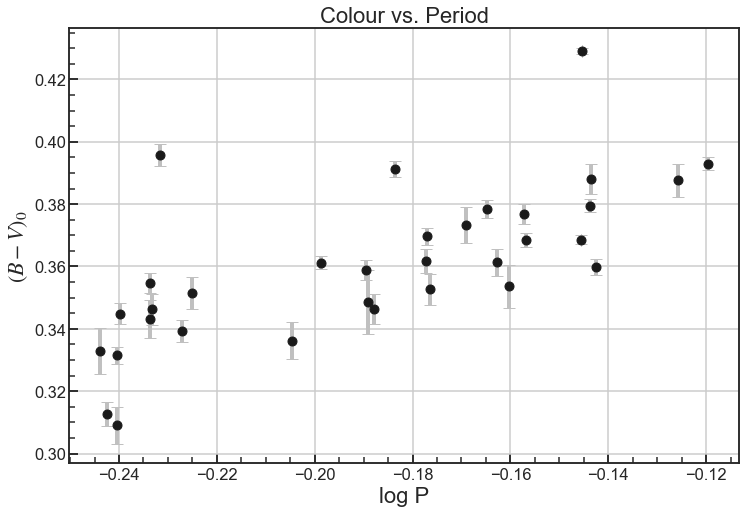

In [33]:
log_period_err_ab = (1/np.log(10)) * (summary[RRab]['period_err'][summary[RRab]['[Fe/H]'] < 0]/summary[RRab]['period'][summary[RRab]['[Fe/H]'] < 0])

plt.figure(figsize=(12,8))
plt.title("Colour vs. Period",fontsize=22)
plt.ylabel("$(B - V)_0$",fontsize=22)
plt.xlabel("log P",fontsize=22)
plt.errorbar(np.log10(summary[RRab]['period'][summary[RRab]['[Fe/H]'] < 0]), summary[RRab]['BV_0'][summary[RRab]['[Fe/H]'] < 0], 
             summary[RRab]['err_BV_0'][summary[RRab]['[Fe/H]'] < 0], log_period_err_ab, fmt='o',
            color='k', ecolor='silver', capsize=6)
plt.grid()
#plt.savefig('color_period.pdf', format='pdf', dpi=300, bbox_inches='tight') 
plt.show()

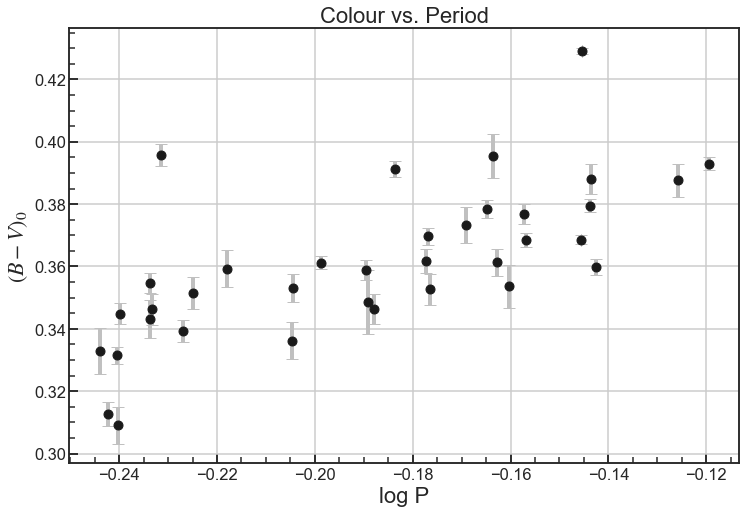

In [152]:
log_period_err_ab = (1/np.log(10)) * (summary[RRab]['period_err']/summary[RRab]['period'])

plt.figure(figsize=(12,8))
plt.title("Colour vs. Period",fontsize=22)
plt.ylabel("$(B - V)_0$",fontsize=22)
plt.xlabel("log P",fontsize=22)
plt.errorbar(np.log10(summary[RRab]['period']), summary[RRab]['BV_0'], 
             summary[RRab]['err_BV_0'], log_period_err_ab, fmt='o',
            color='k', ecolor='silver', capsize=6)
plt.grid()
#plt.savefig('color_period.pdf', format='pdf', dpi=300, bbox_inches='tight') 
plt.show()

0.5698862979104103
0.44497174850113685


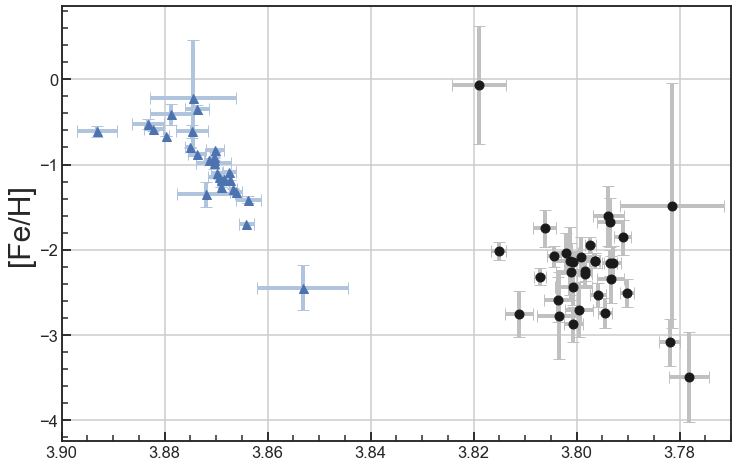

In [181]:
values = summary[RRab]['err_[Fe/H]'][summary[RRab]['[Fe/H]'] < 0]
#print(values)
        
#print(np.std(values))





metallicity_ab = summary[RRab]['[Fe/H]'][summary[RRab]['[Fe/H]'] < 0] 
metallicity_c = summary[RRc]['[Fe/H]'][summary[RRc]['[Fe/H]'] < 0] 


print(np.std(metallicity_ab))
print(np.std(metallicity_c))

fig, (ax1) = plt.subplots(1,1, figsize=(12,8),sharex=True)  # 2 Rows, 1 Column
fig.subplots_adjust(hspace=0)



ax1.set_ylabel("[Fe/H]",fontsize=30)
ax1.errorbar(summary[RRab]['log T_eff'][summary[RRab]['[Fe/H]'] < 0], metallicity_ab,
             summary[RRab]['err_[Fe/H]'][summary[RRab]['[Fe/H]'] < 0], 
             summary[RRab]['err_log T_eff'][summary[RRab]['[Fe/H]'] < 0], fmt='o', color='k',
             ecolor='silver', capsize=6)

ax1.errorbar(summary[RRc]['log T_eff'][summary[RRc]['[Fe/H]'] < 0], metallicity_c,
            summary[RRc]['err_[Fe/H]'][summary[RRc]['[Fe/H]'] < 0], 
            summary[RRc]['err_log T_eff'][summary[RRc]['[Fe/H]'] < 0], fmt='^',
            color='b', ecolor='lightsteelblue', capsize=6)
#ax1.scatter(empirical_temp, metallicity, color='r')
ax1.grid()
ax1.set_xlim(3.9,3.77)

plt.show()

# Trial and Error Plots

In [4]:
# #create a figure with 2 graphs oriented one way
# metallicity = summary[RRc]['[Fe/H]'][summary[RRc]['[Fe/H]'] < 0] 
# #empirical_temp = summary['log T_eff empirical'][summary['[Fe/H]'] < 0]

# print("""Below is the results for RRc Stars""")

# fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(16,18),sharex=True)  # 2 Rows, 1 Column
# fig.subplots_adjust(hspace=0)


# ax1.set_ylabel("[Fe/H]",fontsize=22)
# ax1.scatter(summary[RRc]['phi_31'][summary[RRc]['[Fe/H]'] < 0], metallicity, color='k')
# #ax1.scatter(empirical_temp, metallicity, color='r')
# ax1.grid()

# ax2.set_ylabel("log L",fontsize=22)
# ax2.scatter(summary[RRc]['phi_31'][summary[RRc]['[Fe/H]'] < 0], summary[RRc]['log L'][summary[RRc]['[Fe/H]'] < 0], color='k')
# #ax2.scatter(empirical_temp, summary['log L'][summary['[Fe/H]'] < 0], color='r')
# ax2.grid()

# ax3.set_ylabel("log g",fontsize=22)
# ax3.scatter(summary[RRc]['phi_31'][summary[RRc]['[Fe/H]'] < 0], summary[RRc]['log g'][summary[RRc]['[Fe/H]'] < 0], color='k')
# #ax3.scatter(empirical_temp, summary['log g empirical'][summary['[Fe/H]'] < 0], color='r')
# ax3.grid()

# ax4.set_ylabel("M/$M_\odot$",fontsize=22)
# ax4.scatter(summary[RRc]['phi_31'][summary[RRc]['[Fe/H]'] < 0], summary[RRc]['mass'][summary[RRc]['[Fe/H]'] < 0], color='k',label='Theoretical')
# #ax4.scatter(empirical_temp, summary['mass empirical'][summary['[Fe/H]'] < 0], color='r', label='Empirical')
# ax4.grid()

# ax5.set_ylabel("log P",fontsize=22)
# ax5.set_xlabel("$\\phi_{31}$",fontsize=22)
# ax5.scatter(summary[RRc]['phi_31'][summary[RRc]['[Fe/H]'] < 0], np.log10(summary[RRc]['period'][summary[RRc]['[Fe/H]'] < 0]), color='k',label='Theoretical')
# #ax4.scatter(empirical_temp, summary['mass empirical'][summary['[Fe/H]'] < 0], color='r', label='Empirical')
# ax5.grid()

# #ax4.set_ylim(0,2)
# plt.xlim(2, 3.5)
# #plt.legend()
# plt.savefig('prop_vs_phi_31_c.png', format='png', dpi=300, bbox_inches='tight')
# plt.show()

In [5]:
# fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(16,18),sharex=True)  # 2 Rows, 1 Column
# fig.subplots_adjust(hspace=0)


# ax1.set_ylabel("[Fe/H]",fontsize=22)
# ax1.scatter(summary[RRab]['phi_31'][summary[RRab]['[Fe/H]'] < 0], metallicity_ab, color='k')
# ax1.scatter(summary[RRc]['phi_31'][summary[RRc]['[Fe/H]'] < 0], metallicity_c, color='b')
# #ax1.scatter(empirical_temp, metallicity, color='r')
# ax1.grid()

# ax2.set_ylabel("log L",fontsize=22)
# ax2.scatter(summary[RRab]['phi_31'][summary[RRab]['[Fe/H]'] < 0], summary[RRab]['log L'][summary[RRab]['[Fe/H]'] < 0], color='k')
# ax2.scatter(summary[RRc]['phi_31'][summary[RRc]['[Fe/H]'] < 0], summary[RRc]['log L'][summary[RRc]['[Fe/H]'] < 0], color='b')
# #ax2.scatter(empirical_temp, summary['log L'][summary['[Fe/H]'] < 0], color='r')
# ax2.grid()

# ax3.set_ylabel("log g",fontsize=22)
# ax3.scatter(summary[RRab]['phi_31'][summary[RRab]['[Fe/H]'] < 0], summary[RRab]['log g'][summary[RRab]['[Fe/H]'] < 0], color='k')
# ax3.scatter(summary[RRc]['phi_31'][summary[RRc]['[Fe/H]'] < 0], summary[RRc]['log g'][summary[RRc]['[Fe/H]'] < 0], color='b')
# #ax3.scatter(empirical_temp, summary['log g empirical'][summary['[Fe/H]'] < 0], color='r')
# ax3.grid()

# ax4.set_ylabel("M/$M_\odot$",fontsize=22)
# ax4.set_xlabel("$\\log T_{eff}$",fontsize=22)
# ax4.scatter(summary[RRab]['phi_31'][summary[RRab]['[Fe/H]'] < 0], summary[RRab]['mass'][summary[RRab]['[Fe/H]'] < 0], color='k')
# ax4.scatter(summary[RRc]['phi_31'][summary[RRc]['[Fe/H]'] < 0], summary[RRc]['mass'][summary[RRc]['[Fe/H]'] < 0], color='b')
# #ax4.scatter(empirical_temp, summary['mass empirical'][summary['[Fe/H]'] < 0], color='r', label='Empirical')
# ax4.grid()

# ax5.set_ylabel("log P",fontsize=22)
# ax5.set_xlabel("$\\phi_{31}$",fontsize=22)
# ax5.scatter(summary[RRab]['phi_31'][summary[RRab]['[Fe/H]'] < 0], np.log10(summary[RRab]['period'][summary[RRab]['[Fe/H]'] < 0]), color='k')
# ax5.scatter(summary[RRc]['phi_31'][summary[RRc]['[Fe/H]'] < 0], np.log10(summary[RRc]['period'][summary[RRc]['[Fe/H]'] < 0]), color='b',label='Theoretical')
# #ax4.scatter(empirical_temp, summary['mass empirical'][summary['[Fe/H]'] < 0], color='r', label='Empirical')
# ax5.grid()


# #ax4.set_ylim(.4,1)
# #plt.xlim(3.74, 3.86)

# #plt.legend()
# #plt.savefig('prop_vs_phi31.png', format='png', dpi=300, bbox_inches='tight')
# plt.show()

In [1]:
# #create a figure with 2 graphs oriented one way
# metallicity_ab = summary[RRab]['[Fe/H]'][summary[RRab]['[Fe/H]'] < 0] 
# #empirical_temp = summary['log T_eff empirical'][summary['[Fe/H]'] < 0]

# print("""Below is the results for RRab Stars""")

# fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(16,18),sharex=True)  # 2 Rows, 1 Column
# fig.subplots_adjust(hspace=0)


# ax1.set_ylabel("[Fe/H]",fontsize=22)
# ax1.scatter(summary[RRab]['log T_eff'][summary[RRab]['[Fe/H]'] < 0], metallicity_ab, color='k')
# #ax1.scatter(empirical_temp, metallicity, color='r')
# ax1.grid()

# ax2.set_ylabel("log L",fontsize=22)
# ax2.scatter(summary[RRab]['log T_eff'][summary[RRab]['[Fe/H]'] < 0], summary[RRab]['log L'][summary[RRab]['[Fe/H]'] < 0], color='k')
# #ax2.scatter(empirical_temp, summary['log L'][summary['[Fe/H]'] < 0], color='r')
# ax2.grid()

# ax3.set_ylabel("log g",fontsize=22)
# ax3.scatter(summary[RRab]['log T_eff'][summary[RRab]['[Fe/H]'] < 0], summary[RRab]['log g'][summary[RRab]['[Fe/H]'] < 0], color='k')
# #ax3.scatter(empirical_temp, summary['log g empirical'][summary['[Fe/H]'] < 0], color='r')
# ax3.grid()

# ax4.set_ylabel("M/$M_\odot$",fontsize=22)
# ax4.set_xlabel("$\\log T_{eff}$",fontsize=22)
# ax4.scatter(summary[RRab]['log T_eff'][summary[RRab]['[Fe/H]'] < 0], summary[RRab]['mass'][summary[RRab]['[Fe/H]'] < 0], color='k',label='Theoretical')
# #ax4.scatter(empirical_temp, summary['mass empirical'][summary['[Fe/H]'] < 0], color='r', label='Empirical')
# ax4.grid()

# ax5.set_ylabel("log P",fontsize=22)
# ax5.set_xlabel("$\\log T_{eff}$",fontsize=22)
# ax5.scatter(summary[RRab]['log T_eff'][summary[RRab]['[Fe/H]'] < 0], np.log10(summary[RRab]['period'][summary[RRab]['[Fe/H]'] < 0]), color='k',label='Theoretical')
# #ax4.scatter(empirical_temp, summary['mass empirical'][summary['[Fe/H]'] < 0], color='r', label='Empirical')
# ax5.grid()


# ax4.set_ylim(.4,1)
# plt.xlim(3.74, 3.86)
# #plt.legend()
# #plt.savefig('prop_vs_Teff_ab.png', format='png', dpi=300, bbox_inches='tight')
# plt.show()

In [2]:
# #create a figure with 2 graphs oriented one way
# #create a figure with 2 graphs oriented one way
# metallicity_ab = summary[RRab]['[Fe/H]'][summary[RRab]['[Fe/H]'] < 0] 
# metallicity_c = summary[RRc]['[Fe/H]'][summary[RRc]['[Fe/H]'] < 0] 
# #empirical_temp = summary['log T_eff empirical'][summary['[Fe/H]'] < 0]

# print("""Below is the results for RRc Stars""")

# fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(16,18),sharex=True)  # 2 Rows, 1 Column
# fig.subplots_adjust(hspace=0)


# ax1.set_ylabel("[Fe/H]",fontsize=22)
# ax1.scatter(summary[RRc]['log T_eff'][summary[RRc]['[Fe/H]'] < 0], metallicity_c, color='k')
# #ax1.scatter(empirical_temp, metallicity, color='r')
# ax1.grid()

# ax2.set_ylabel("log L",fontsize=22)
# ax2.scatter(summary[RRc]['log T_eff'][summary[RRc]['[Fe/H]'] < 0], summary[RRc]['log L'][summary[RRc]['[Fe/H]'] < 0], color='k')
# #ax2.scatter(empirical_temp, summary['log L'][summary['[Fe/H]'] < 0], color='r')
# ax2.grid()

# ax3.set_ylabel("log g",fontsize=22)
# ax3.scatter(summary[RRc]['log T_eff'][summary[RRc]['[Fe/H]'] < 0], summary[RRc]['log g'][summary[RRc]['[Fe/H]'] < 0], color='k')
# #ax3.scatter(empirical_temp, summary['log g empirical'][summary['[Fe/H]'] < 0], color='r')
# ax3.grid()

# ax4.set_ylabel("M/$M_\odot$",fontsize=22)
# ax4.set_xlabel("$\\log T_{eff}$",fontsize=22)
# ax4.scatter(summary[RRc]['log T_eff'][summary[RRc]['[Fe/H]'] < 0], summary[RRc]['mass'][summary[RRc]['[Fe/H]'] < 0], color='k',label='Theoretical')
# #ax4.scatter(empirical_temp, summary['mass empirical'][summary['[Fe/H]'] < 0], color='r', label='Empirical')
# ax4.grid()

# ax5.set_ylabel("log P",fontsize=22)
# ax5.set_xlabel("$\\log T_{eff}$",fontsize=22)
# ax5.scatter(summary[RRc]['log T_eff'][summary[RRc]['[Fe/H]'] < 0], np.log10(summary[RRc]['period'][summary[RRc]['[Fe/H]'] < 0]), color='k',label='Theoretical')
# #ax4.scatter(empirical_temp, summary['mass empirical'][summary['[Fe/H]'] < 0], color='r', label='Empirical')
# ax5.grid()

# #ax4.set_ylim(0,2)
# plt.xlim(3.86, 3.88)
# #plt.legend()
# #plt.savefig('prop_vs_Teff_c.png', format='png', dpi=300, bbox_inches='tight')
# plt.show()

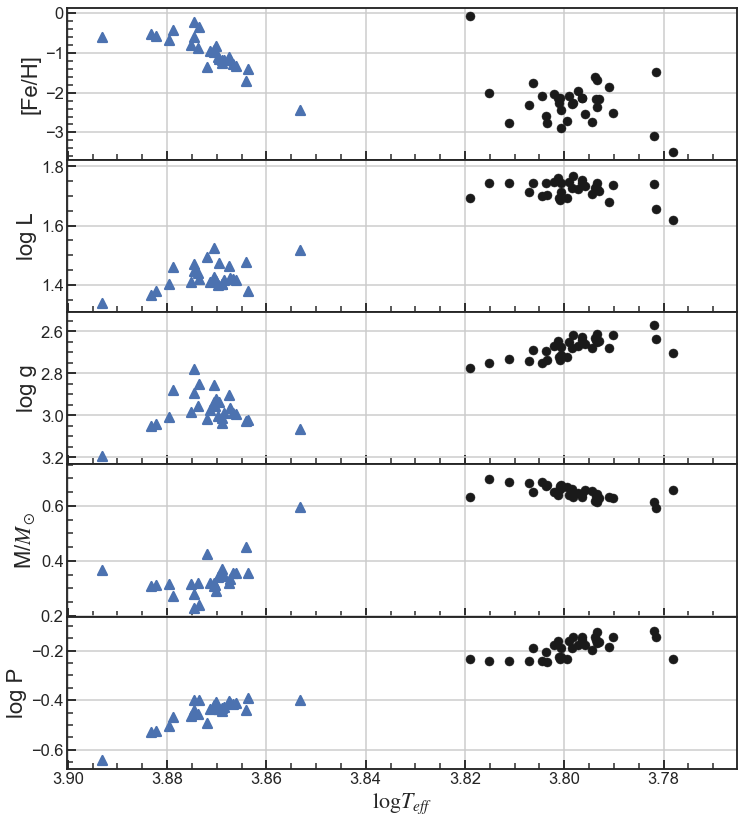

In [18]:
#create a figure with 2 graphs oriented one way
#create a figure with 2 graphs oriented one way
metallicity_ab = summary[RRab]['[Fe/H]'][summary[RRab]['[Fe/H]'] < 0] 
metallicity_c = summary[RRc]['[Fe/H]'][summary[RRc]['[Fe/H]'] < 0] 
#empirical_temp = summary['log T_eff empirical'][summary['[Fe/H]'] < 0]

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(12,14),sharex=True)  # 2 Rows, 1 Column
fig.subplots_adjust(hspace=0)


ax1.set_ylabel("[Fe/H]",fontsize=22)
ax1.scatter(summary[RRab]['log T_eff'][summary[RRab]['[Fe/H]'] < 0], metallicity_ab, color='k', linewidth='0.5')
ax1.scatter(summary[RRc]['log T_eff'][summary[RRc]['[Fe/H]'] < 0], metallicity_c, color='b', marker='^')
#ax1.scatter(empirical_temp, metallicity, color='r')
ax1.grid()

ax2.set_ylabel("log L",fontsize=22)
ax2.scatter(summary[RRab]['log T_eff'][summary[RRab]['[Fe/H]'] < 0], summary[RRab]['log L'][summary[RRab]['[Fe/H]'] < 0], color='k', linewidth='0.5')
ax2.scatter(summary[RRc]['log T_eff'][summary[RRc]['[Fe/H]'] < 0], summary[RRc]['log L'][summary[RRc]['[Fe/H]'] < 0], color='b', marker='^')
#ax2.scatter(empirical_temp, summary['log L'][summary['[Fe/H]'] < 0], color='r')
ax2.grid()

ax3.set_ylabel("log g",fontsize=22)
ax3.scatter(summary[RRab]['log T_eff'][summary[RRab]['[Fe/H]'] < 0], summary[RRab]['log g'][summary[RRab]['[Fe/H]'] < 0], color='k', linewidth='0.5')
ax3.scatter(summary[RRc]['log T_eff'][summary[RRc]['[Fe/H]'] < 0], summary[RRc]['log g'][summary[RRc]['[Fe/H]'] < 0], color='b', marker='^')
#ax3.scatter(empirical_temp, summary['log g empirical'][summary['[Fe/H]'] < 0], color='r')
ax3.invert_yaxis()
ax3.grid()

ax4.set_ylabel("M/$M_\odot$",fontsize=22)
ax4.set_xlabel("$\\log T_{eff}$",fontsize=22)
ax4.scatter(summary[RRab]['log T_eff'][summary[RRab]['[Fe/H]'] < 0], summary[RRab]['mass'][summary[RRab]['[Fe/H]'] < 0], color='k', linewidth='0.5')
ax4.scatter(summary[RRc]['log T_eff'][summary[RRc]['[Fe/H]'] < 0], summary[RRc]['mass'][summary[RRc]['[Fe/H]'] < 0], color='b', marker='^')
#ax4.scatter(empirical_temp, summary['mass empirical'][summary['[Fe/H]'] < 0], color='r', label='Empirical')
ax4.grid()

ax5.set_ylabel("log P",fontsize=22)
ax5.set_xlabel("$\\log T_{eff}$",fontsize=22)
ax5.scatter(summary[RRab]['log T_eff'][summary[RRab]['[Fe/H]'] < 0], np.log10(summary[RRab]['period'][summary[RRab]['[Fe/H]'] < 0]), color='k', linewidth='0.5')
ax5.scatter(summary[RRc]['log T_eff'][summary[RRc]['[Fe/H]'] < 0], np.log10(summary[RRc]['period'][summary[RRc]['[Fe/H]'] < 0]), color='b', marker='^',label='Theoretical')
#ax4.scatter(empirical_temp, summary['mass empirical'][summary['[Fe/H]'] < 0], color='r', label='Empirical')
ax5.grid()


#ax4.set_ylim(.4,1)
#plt.xlim(3.74, 3.86)
#plt.legend()
ax5.invert_xaxis()
plt.savefig('prop_vs_Teff_fixed.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [3]:
# #create a figure with 2 graphs oriented one way
# metallicity = summary[RRab]['[Fe/H]'][summary[RRab]['[Fe/H]'] < 0] 
# #empirical_temp = summary['log T_eff empirical'][summary['[Fe/H]'] < 0]

# print("""Below is the results for RRab Stars""")

# fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(16,18),sharex=True)  # 2 Rows, 1 Column
# fig.subplots_adjust(hspace=0)


# ax1.set_ylabel("[Fe/H]",fontsize=22)
# ax1.scatter(summary[RRab]['phi_31'][summary[RRab]['[Fe/H]'] < 0], metallicity, color='k')
# #ax1.scatter(empirical_temp, metallicity, color='r')
# ax1.grid()

# ax2.set_ylabel("log L",fontsize=22)
# ax2.scatter(summary[RRab]['phi_31'][summary[RRab]['[Fe/H]'] < 0], summary[RRab]['log L'][summary[RRab]['[Fe/H]'] < 0], color='k')
# #ax2.scatter(empirical_temp, summary['log L'][summary['[Fe/H]'] < 0], color='r')
# ax2.grid()

# ax3.set_ylabel("log g",fontsize=22)
# ax3.scatter(summary[RRab]['phi_31'][summary[RRab]['[Fe/H]'] < 0], summary[RRab]['log g'][summary[RRab]['[Fe/H]'] < 0], color='k')
# #ax3.scatter(empirical_temp, summary['log g empirical'][summary['[Fe/H]'] < 0], color='r')
# ax3.grid()

# ax4.set_ylabel("M/$M_\odot$",fontsize=22)
# #ax4.set_xlabel("$\\phi_{31}$",fontsize=22)
# ax4.scatter(summary[RRab]['phi_31'][summary[RRab]['[Fe/H]'] < 0], summary[RRab]['mass'][summary[RRab]['[Fe/H]'] < 0], color='k',label='Theoretical')
# #ax4.scatter(empirical_temp, summary['mass empirical'][summary['[Fe/H]'] < 0], color='r', label='Empirical')
# ax4.grid()

# ax5.set_ylabel("log P",fontsize=22)
# ax5.set_xlabel("$\\phi_{31}$",fontsize=22)
# ax5.scatter(summary[RRab]['phi_31'][summary[RRab]['[Fe/H]'] < 0], np.log10(summary[RRab]['period'][summary[RRab]['[Fe/H]'] < 0]), color='k',label='Theoretical')
# #ax4.scatter(empirical_temp, summary['mass empirical'][summary['[Fe/H]'] < 0], color='r', label='Empirical')
# ax5.grid()


# #ax4.set_ylim(.4,1)
# #plt.xlim(3.74, 3.86)
# #plt.legend()
# #plt.savefig('prop_vs_phi_31_ab.png', format='png', dpi=300, bbox_inches='tight')
# plt.show()

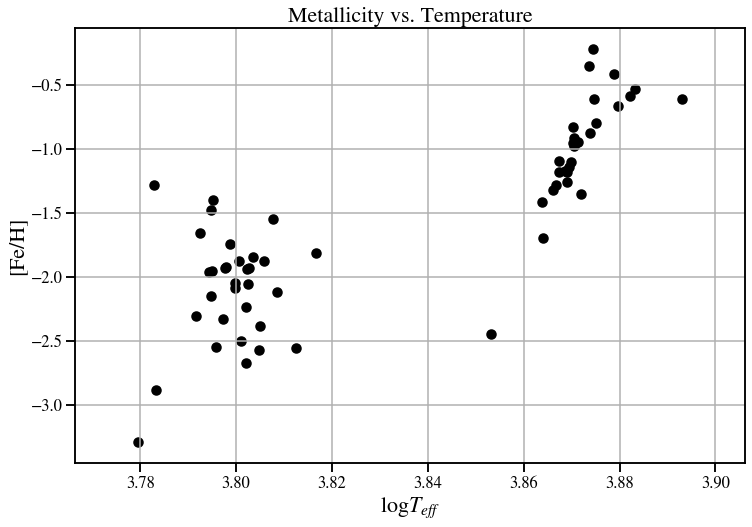

In [191]:
plt.figure(figsize=(12,8))
plt.title("Metallicity vs. Temperature",fontsize=22)
plt.ylabel("[Fe/H]",fontsize=22)
plt.xlabel("$\\log T_{eff}$",fontsize=22)
plt.scatter(summary['log T_eff'][summary['[Fe/H]'] < 0], summary['[Fe/H]'][summary['[Fe/H]'] < 0], color='k')
plt.grid()
plt.show()